# Seurat Notebook

State the hypothesis/main goal of this notebook.

#### Approach
Input - raw count matrix

1. preprocess
  1. QC
  2. batch effect corrections
  3. cell cycle regression
  4. scaling
2.  clustering
  1. feature selection
  2. dimensional reduction
  3. clustering
3. DE


# Setup the Seurat Object

For this tutorial, we will be analyzing the a dataset of Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500. The raw data can be found [here](https://s3-us-west-2.amazonaws.com/10x.files/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

We start by reading in the data. All features in Seurat have been configured to work with sparse matrices which results in significant memory and speed savings for Drop-seq/inDrop/10x data.

In [1]:
library(Seurat)
library(dplyr)
library(Matrix)

Loading required package: ggplot2
Loading required package: cowplot

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave

Loading required package: Matrix

Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [30]:
# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "~/Downloads/filtered_gene_bc_matrices/hg19/")

Initialize the Seurat object with the raw (non-normalized data).

Keep all genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at least 200 detected genes.

In [5]:
pbmc <- CreateSeuratObject(raw.data = pbmc.data, min.cells = 3, min.genes = 200, project = "10X_PBMC")

# Standard pre-processing workflow
The steps below encompass the standard pre-processing workflow for scRNA-seq data in Seurat. These represent the creation of a Seurat object, the selection and filtration of cells based on QC metrics, data normalization and scaling, and the detection of highly variable genes. In previous versions, we grouped many of these steps together in the `Setup` function, but in v2, we separate these steps into a clear and sequential workflow.

## QC and selecting cells for further analysis
While the `CreateSeuratObject` imposes a basic minimum gene-cutoff, you may want to filter out cells at this stage based on technical or biological parameters. Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. In the example below, we visualize gene and molecule counts, plot their relationship, and exclude cells with a clear outlier number of genes detected as potential multiplets. Of course this is not a guaranteed method to exclude cell doublets, but we include this as an example of filtering user-defined outlier cells. We also filter cells based on the percentage of mitochondrial genes present.

The number of genes and UMIs (nGene and nUMI) are automatically calculated for every object by Seurat.
For non-UMI data, nUMI represents the sum of the non-normalized values within a cell. We calculate the percentage of mitochondrial genes here and store it in percent.mito using AddMetaData. We use object@raw.data since this represents non-transformed and non-log-normalized counts

The % of UMI mapping to MT-genes is a common scRNA-seq QC metric.

**NOTE**: You must have the Matrix package loaded to calculate the percent.mito values.

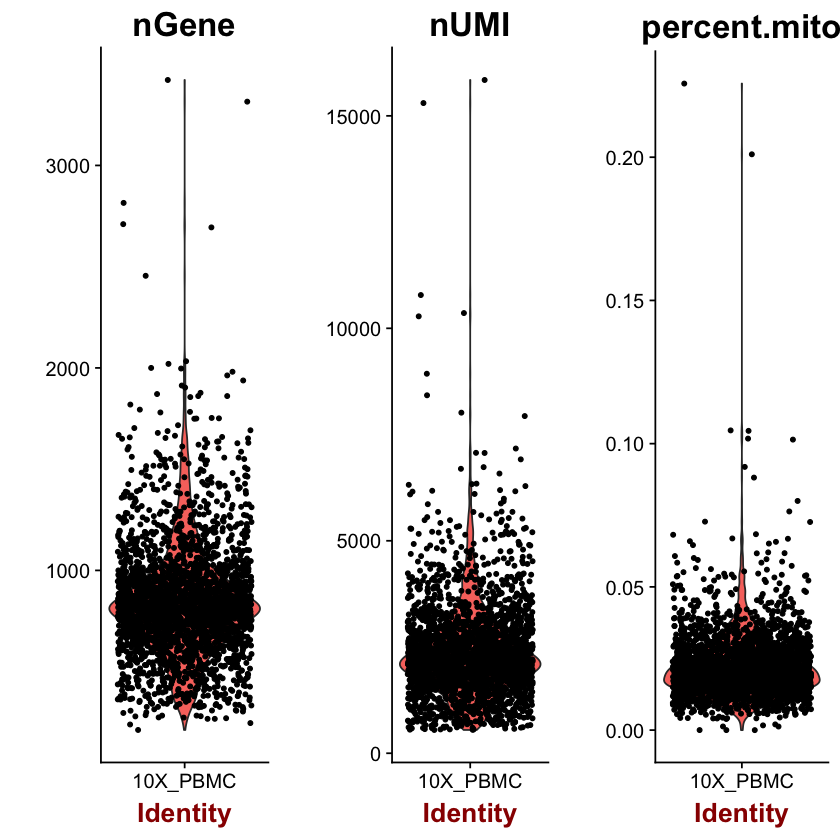

In [6]:
mito.genes <- grep(pattern = "^MT-", x = rownames(x = pbmc@data), value = TRUE)
percent.mito <- Matrix::colSums(pbmc@raw.data[mito.genes, ]) / Matrix::colSums(pbmc@raw.data)

# AddMetaData adds columns to object@meta.data, and is a great place to stash QC stats
pbmc <- AddMetaData(object = pbmc, metadata = percent.mito, col.name = "percent.mito")
VlnPlot(object = pbmc, features.plot = c("nGene", "nUMI", "percent.mito"), nCol = 3)

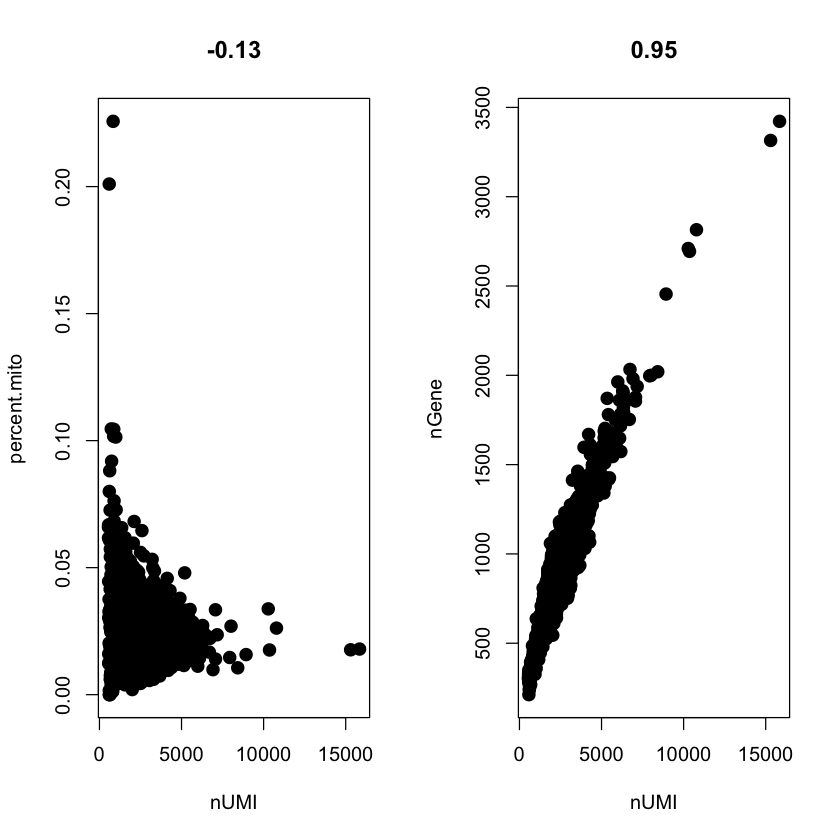

In [7]:
# GenePlot is typically used to visualize gene-gene relationships, but can be used for anything 
# calculated by the object, i.e. columns in object@meta.data, PC scores etc.
# Since there is a rare subset of cells with an outlier level of high mitochondrial percentage
# and also low UMI content, we filter these as well
par(mfrow = c(1, 2))
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "percent.mito")
GenePlot(object = pbmc, gene1 = "nUMI", gene2 = "nGene")

In [8]:
# We filter out cells that have unique gene counts over 2,500 or less than 200
# Note that low.thresholds and high.thresholds are used to define a 'gate'
# -Inf and Inf should be used if you don't want a lower or upper threshold.
pbmc <- FilterCells(object = pbmc, subset.names = c("nGene", "percent.mito"), low.thresholds = c(200, -Inf), high.thresholds = c(2500, 0.05))

# Normalizing the data

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method "LogNormalize" that normalizes the gene expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

In [9]:
pbmc <- NormalizeData(object = pbmc, normalization.method = "LogNormalize", scale.factor = 1e4)

# Detection of variable genes across the single cells

Seurat calculates highly variable genes and focuses on these for downstream analysis. **`FindVariableGenes`** calculates the average expression and dispersion for each gene, places these genes into bins, and then calculates a z-score for dispersion within each bin. This helps control for the relationship between variability and average expression. This function is unchanged from (Macosko *et al*.), but new methods for variable gene expression identification are coming soon. We suggest that users set these parameters to mark visual outliers on the dispersion plot, but the exact parameter settings may vary based on the data type, heterogeneity in the sample, and normalization strategy. The parameters here identify ~2,000 variable genes, and represent typical parameter settings for UMI data that is normalized to a total of 1e4 molecules.

[1] 1838

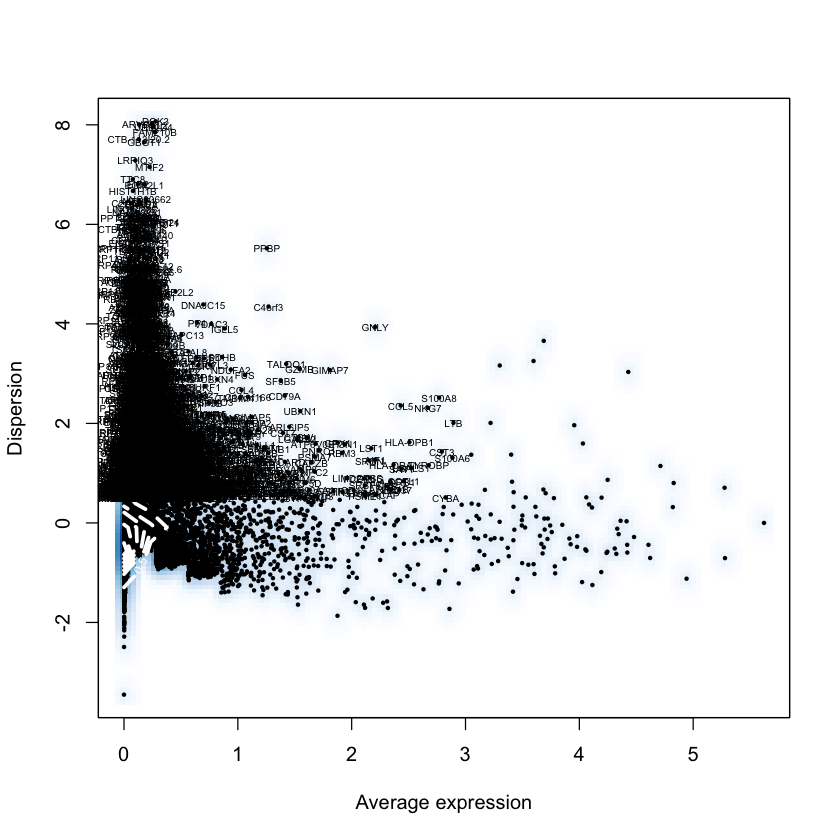

In [10]:
# PUT IN CLUSTERING?
pbmc <- FindVariableGenes(object = pbmc, mean.function = ExpMean, dispersion.function = LogVMR, x.low.cutoff = 0.0125, x.high.cutoff = 3, y.cutoff = 0.5)

length(x = pbmc@var.genes)

# Scaling the data and removing unwanted sources of variation

Your single cell dataset likely contains 'uninteresting' sources of variation. This could include not only technical noise, but batch effects, or even biological sources of variation (cell cycle stage). As suggested in Buettner *et al*, NBT, 2015, regressing these signals out of the analysis can improve downstream dimensionality reduction and clustering. To mitigate the effect of these signals, Seurat constructs linear models to predict gene expression based on user-defined variables. The scaled z-scored residuals of these models are stored in the scale.data slot, and  are used for dimensionality reduction and clustering. 

We can regress out cell-cell variation in gene expression driven by batch (if applicable), cell alignment rate (as provided by Drop-seq tools for Drop-seq data),  the number of detected molecules, and mitochondrial gene expression. For cycling cells, we can also learn a 'cell-cycle' score (see example [HERE](ScaleData(object = marrow, vars.to.regress = c("S.Score", "G2M.Score"), display.progress = FALSE)) and regress this out as well. In this simple example here for post-mitotic blood cells, we regress on the number of detected molecules per cell as well as the percentage mitochondrial gene content.  

Seurat v2.0 implements this regression as part of the data scaling process. Therefore, the `RegressOut` function has been deprecated, and replaced with the vars.to.regress argument in `ScaleData`.

In [11]:
pbmc <- ScaleData(object = pbmc, vars.to.regress = c("nUMI", "percent.mito"))

[1] "Regressing out nUMI"         "Regressing out percent.mito"
  |======================================================================| 100%
[1] "Scaling data matrix"
  |======================================================================| 100%


# cell cycle?

# Perform linear dimensional reduction

Next we perform PCA on the scaled data. By default, the genes in `object@var.genes` are used as input, but can be defined using pc.genes. We have typically found that running dimensionality reduction on highly variable genes can improve performance. However, with UMI data - particularly after regressing out technical variables, we often see that PCA returns similar (albeit slower) results when run on much larger subsets of genes, including the whole transcriptome.

In [12]:
pbmc <- RunPCA(object = pbmc, pc.genes = pbmc@var.genes, do.print = TRUE, pcs.print = 1:5, genes.print = 5)

[1] "PC1"
[1] "CST3"   "TYROBP" "FCN1"   "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC3"
[1] "PF4"   "PPBP"  "SDPR"  "SPARC" "GNG11"
[1] ""
[1] "CYBA"     "HLA-DPA1" "HLA-DPB1" "HLA-DRB1" "CD37"    
[1] ""
[1] ""
[1] "PC4"
[1] "IL32"   "GIMAP7" "AQP3"   "FYB"    "MAL"   
[1] ""
[1] "CD79A"    "HLA-DQA1" "CD79B"    "MS4A1"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC5"
[1] "FCGR3A"        "CTD-2006K23.1" "IFITM3"        "ABI3"         
[5] "CEBPB"        
[1] ""
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] ""


Seurat provides several useful ways of visualizing both cells and genes that define the PCA, including `PrintPCA`, `VizPCA`, `PCAPlot`, and `PCHeatmap`.

[1] "PC1"
[1] "CST3"   "TYROBP" "FCN1"   "LST1"   "AIF1"  
[1] ""
[1] "PTPRCAP" "IL32"    "LTB"     "CD2"     "CTSW"   
[1] ""
[1] ""
[1] "PC2"
[1] "NKG7" "GZMB" "PRF1" "CST7" "GZMA"
[1] ""
[1] "CD79A"    "MS4A1"    "HLA-DQA1" "TCL1A"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC3"
[1] "PF4"   "PPBP"  "SDPR"  "SPARC" "GNG11"
[1] ""
[1] "CYBA"     "HLA-DPA1" "HLA-DPB1" "HLA-DRB1" "CD37"    
[1] ""
[1] ""
[1] "PC4"
[1] "IL32"   "GIMAP7" "AQP3"   "FYB"    "MAL"   
[1] ""
[1] "CD79A"    "HLA-DQA1" "CD79B"    "MS4A1"    "HLA-DQB1"
[1] ""
[1] ""
[1] "PC5"
[1] "FCGR3A"        "CTD-2006K23.1" "IFITM3"        "ABI3"         
[5] "CEBPB"        
[1] ""
[1] "FCER1A"  "LGALS2"  "MS4A6A"  "S100A8"  "CLEC10A"
[1] ""
[1] ""


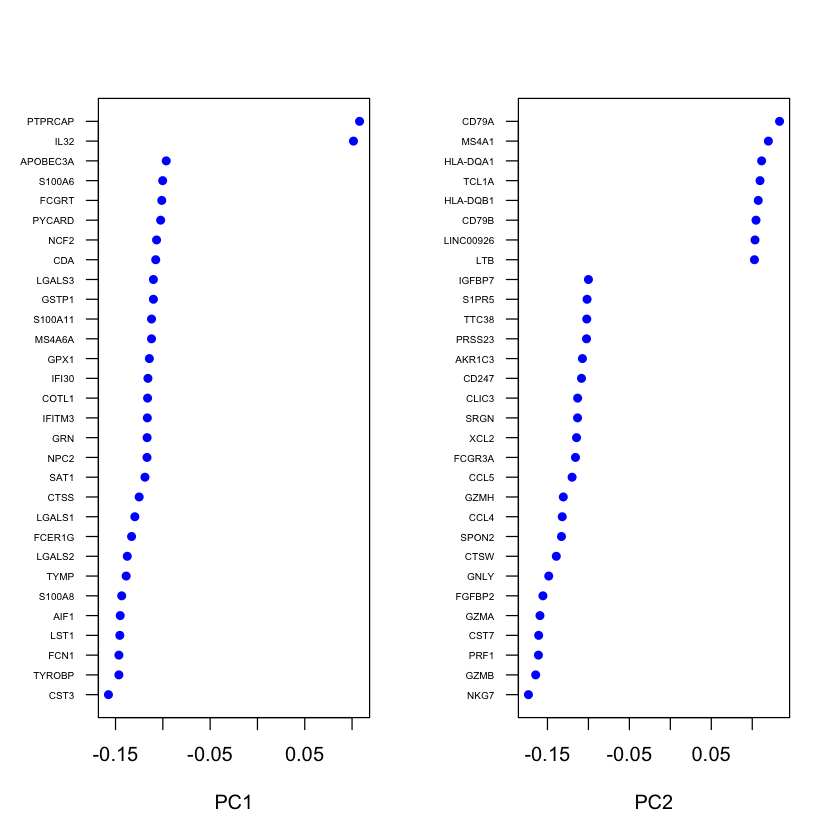

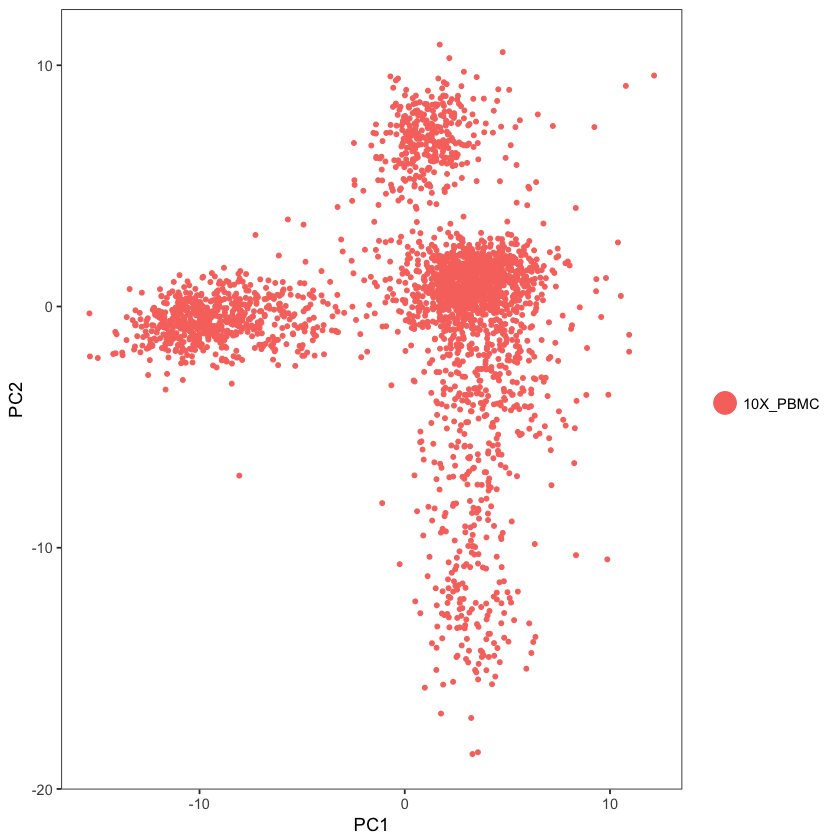

In [13]:
# Examine and visualize PCA results a few different ways
PrintPCA(object = pbmc, pcs.print = 1:5, genes.print = 5, use.full = FALSE)
VizPCA(object = pbmc, pcs.use = 1:2)
PCAPlot(object = pbmc, dim.1 = 1, dim.2 = 2)

ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation with the calculated components. Though we don't use this further here, it can be used to identify markers that are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection. The results of the projected PCA can be explored by setting use.full=T in the functions above.

In [14]:
pbmc <- ProjectPCA(object = pbmc, do.print = FALSE)

In particular `PCHeatmap` allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and genes are ordered according to their PCA scores. Setting cells.use to a number plots the 'extreme' cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated gene sets.

Warning message in heatmap.2(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Rowv is FALSE, while dendrogram is `both'. Omitting row dendogram.”Warning message in heatmap.2(data.use, Rowv = NA, Colv = NA, trace = "none", col = col.use, :
“Discrepancy: Colv is FALSE, while dendrogram is `column'. Omitting column dendogram.”Warning message in plot.window(...):
“"dimTitle" is not a graphical parameter”Warning message in plot.xy(xy, type, ...):
“"dimTitle" is not a graphical parameter”Warning message in title(...):
“"dimTitle" is not a graphical parameter”

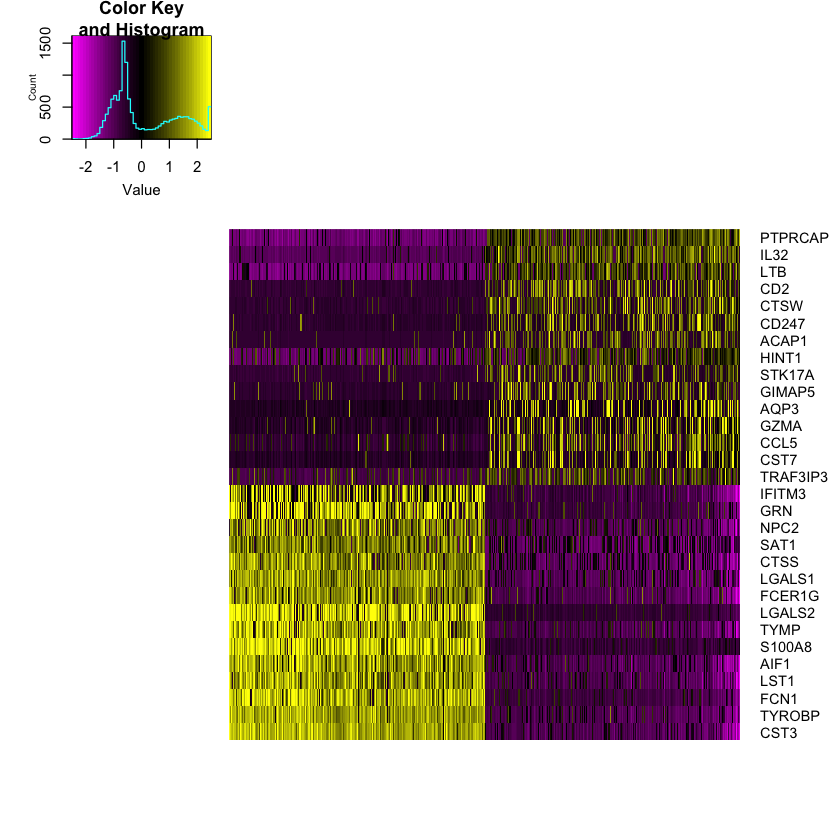

In [15]:
PCHeatmap(object = pbmc, pc.use = 1, cells.use = 500, do.balanced = TRUE, label.columns = FALSE)

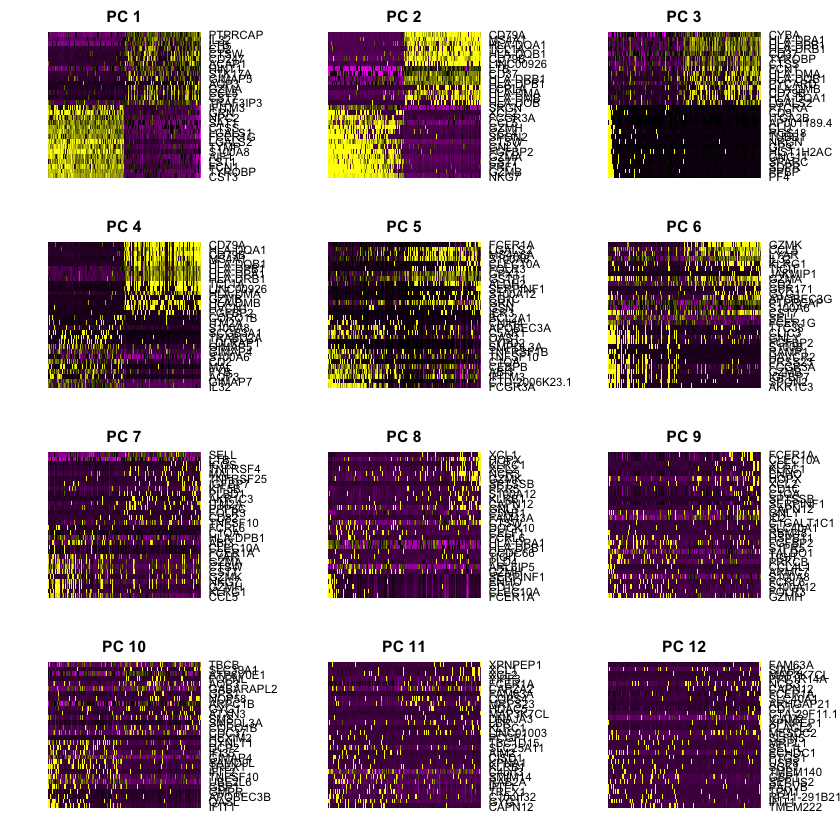

In [16]:
PCHeatmap(object = pbmc, pc.use = 1:12, cells.use = 500, do.balanced = TRUE, label.columns = FALSE, use.full = FALSE)

# Determine statistically significant principal components

To overcome the extensive technical noise in any single gene for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a 'metagene' that combines information across a correlated gene set. Determining how many PCs to include downstream is therefore an important step.

In Macosko *et al*, we implemented a resampling test inspired by the jackStraw procedure. We randomly permute a subset of the data (1% by default) and rerun PCA, constructing a 'null distribution' of gene scores, and repeat this procedure. We identify 'significant' PCs as those who have a strong enrichment of low p-value genes.

In [67]:
# NOTE: This process can take a long time for big datasets, comment out for expediency.
# More approximate techniques such as those implemented in PCElbowPlot() can be used to reduce computation time
pbmc <- JackStraw(object = pbmc, num.replicate = 20, do.print = FALSE)

The `JackStrawPlot` function provides a visualization tool for comparing the distribution of p-values for each PC with a uniform distribution (dashed line). 'Significant' PCs will show a strong enrichment of genes with low p-values (solid curve above the dashed line). In this case it appears that PCs 1-10 are significant.

In [247]:
match(FALSE, c(FALSE, TRUE, FALSE))

[1] 1

In [70]:
JackStrawPlot(pbmc, PCs = 1:12)

A more ad hoc method for determining which PCs to use is to look at a plot of the standard deviations of the principle components and draw your cutoff where there is a clear elbow in the graph. This can be done with `PCElbowPlot`. In this example, it looks like the elbow would fall around PC 9.

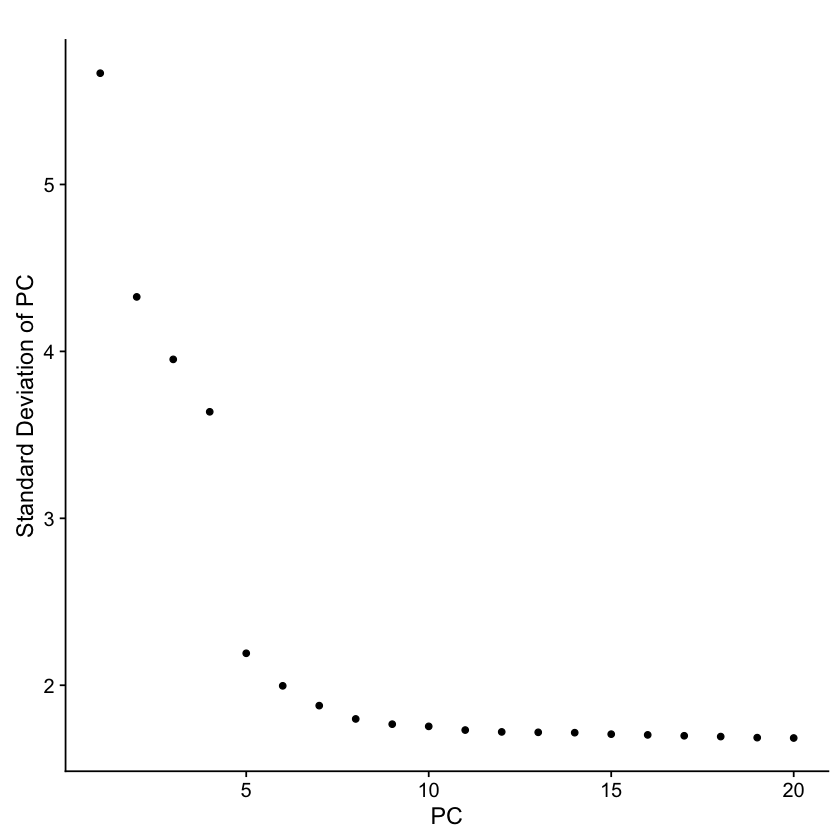

In [18]:
PCElbowPlot(object = pbmc)

PC selection -- identifying the true dimensionality of a dataset -- is an important step for Seurat, but can be challenging/uncertain for the user. We therefore suggest these three approaches to consider. The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example. The second implements a statistical test based on a random null model, but is time-consuming for large datasets, and may not return a clear PC cutoff. The third is a heuristic that is commonly used, and can be calculated instantly. In this example, all three approaches yielded similar results, but we might have been justified in choosing anything between PC 7-10 as a cutoff. We followed the jackStraw  here, admittedly buoyed by seeing the PCHeatmap returning interpretable signals (including canonical dendritic cell markers) throughout these PCs. Though the results are only subtly affected by small shifts in this cutoff (you can test below), we strongly suggest always explore the PCs they choose to include downstream.

# Cluster the cells

Seurat now includes an graph-based clustering approach compared to (Macosko *et al*.). Importantly, the *distance metric* which drives the clustering analysis (based on previously identified PCs) remains the same. However, our approach to partioning the cellular distance matrix into clusters has dramatically improved. Our approach was heavily inspired by recent manuscripts which applied graph-based clustering approaches to scRNA-seq data [[SNN-Cliq, Xu and Su, Bioinformatics, 2015]](http://bioinformatics.oxfordjournals.org/content/early/2015/02/10/bioinformatics.btv088.abstract) and CyTOF data [[PhenoGraph, Levine *et al*., Cell, 2015]](http://www.ncbi.nlm.nih.gov/pubmed/26095251). Briefly, these methods embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar gene expression patterns, and then attempt to partition this graph into highly interconnected 'quasi-cliques' or 'communities'. As in PhenoGraph, we first construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard distance). To cluster the cells, we apply modularity optimization techniques [[SLM, Blondel *et al*., Journal of Statistical Mechanics]](http://dx.doi.org/10.1088/1742-5468/2008/10/P10008), to iteratively group cells together, with the goal of optimizing the standard modularity function.

The `FindClusters` function implements the procedure, and contains a resolution parameter that sets the 'granularity' of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 0.6-1.2 typically returns good results for single cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters are saved in the `object@ident` slot.

In [19]:
# save.SNN = T saves the SNN so that the clustering algorithm can be rerun using the same graph
# but with a different resolution value (see docs for full details)
pbmc <- FindClusters(object = pbmc, reduction.type = "pca", dims.use = 1:10, resolution = 0.6, print.output = 0, save.SNN = TRUE)

A useful feature in Seurat v2.0 is the ability to recall the parameters that were used in the latest function calls for commonly used functions. For FindClusters, we provide the function `PrintFindClustersParams` to print a nicely formatted formatted summary of the parameters that were chosen. 

In [20]:
PrintFindClustersParams(object = pbmc)
# While we do provide function-specific printing functions, the more general function to 
# print calculation parameters is PrintCalcParams(). 

Parameters used in latest FindClusters calculation run on: 2017-11-07 14:59:57
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10



# Run Non-linear dimensional reduction (tSNE)

Seurat continues to use tSNE as a powerful tool to visualize and explore these datasets. While we no longer advise clustering directly on tSNE components, cells within the graph-based clusters determined above should co-localize on the tSNE plot. This is because the tSNE aims to place cells with similar local neighborhoods in high-dimensional space together in low-dimensional space. As input to the tSNE, we suggest using the same PCs as input to the clustering analysis, although computing the tSNE based on scaled gene expression is also supported using the genes.use argument.

In [21]:
pbmc <- RunTSNE(object = pbmc, dims.use = 1:10, do.fast = TRUE)

[1] "list"

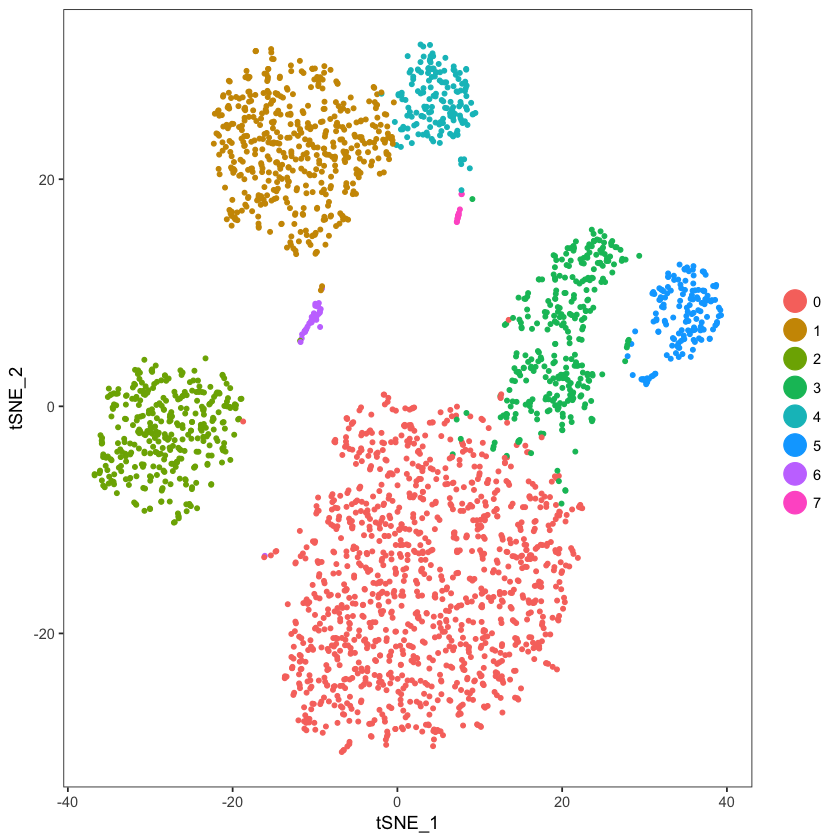

In [263]:
# note that you can set do.label=T to help label individual clusters
TSNEPlot(object = pbmc)

In [262]:
temp$plot

[1] "gg"     "ggplot"

You can save the object at this point so that it can easily be loaded back in without having to rerun the computationally intensive steps performed above, or easily shared with collaborators.

In [ ]:
save(pbmc, file = "~/Projects/datasets/pbmc3k/pbmc_tutorial.Robj")

# Finding differentially expressed genes (cluster biomarkers)

Seurat can help you find markers that define clusters via differential expression. By default, it identifes positive and negative markers of a single cluster (specified in `ident.1`), compared to all other cells.  `FindAllMarkers` automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The min.pct argument requires a gene to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a gene to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of genes that are unlikely to be highly discriminatory. As another option to speed up these computations, max.cells.per.ident can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significiant and the most highly differentially expressed genes will likely still rise to the top.

In [ ]:
# find all markers of cluster 1
cluster1.markers <- FindMarkers(object = pbmc, ident.1 = 1, min.pct = 0.25)
print(x = head(x = cluster1.markers, n = 5))
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(object = pbmc, ident.1 = 5, ident.2 = c(0,3), min.pct = 0.25)
print(x = head(x = cluster5.markers, n = 5))
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(object = pbmc, only.pos = TRUE, min.pct = 0.25, thresh.use = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(2, avg_logFC)

Seurat has four tests for differential expression which can be set with the test.use parameter: ROC test ("roc"), t-test ("t"), LRT test based on zero-inflated data ("bimod", default), LRT test based on tobit-censoring models ("tobit") The ROC test returns the 'classification power' for any individual marker (ranging from 0 - random, to 1 - perfect).

In [ ]:
cluster1.markers <- FindMarkers(object = pbmc, ident.1 = 0, thresh.use = 0.25, test.use = "roc", only.pos = TRUE)

We include several tools for visualizing marker expression. `VlnPlot` (shows expression probability distributions across clusters), and `FeaturePlot` (visualizes gene expression on a tSNE or PCA plot) are our most commonly used visualizations. We also suggest exploring `JoyPlot`, `CellPlot`, and `DotPlot` as additional methods to view your dataset.

In [ ]:
VlnPlot(object = pbmc, features.plot = c("MS4A1", "CD79A"))

# you can plot raw UMI counts as well
VlnPlot(object = pbmc, features.plot = c("NKG7", "PF4"), use.raw = TRUE, y.log = TRUE)

FeaturePlot(object = pbmc, features.plot = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"), cols.use = c("grey", "blue"), reduction.use = "tsne")

`DoHeatmap` generates an expression heatmap for given cells and genes. In this case, we are plotting the top 20 markers (or all markers if less than 20) for each cluster.

In [ ]:
pbmc.markers %>% group_by(cluster) %>% top_n(10, avg_logFC) -> top10
# setting slim.col.label to TRUE will print just the cluster IDS instead of every cell name
DoHeatmap(object = pbmc, genes.use = top10$gene, slim.col.label = TRUE, remove.key = TRUE)

# Assigning cell type identity to clusters

Fortunately in the case of this dataset, we can use canonical markers to easily match the unbiased clustering to known cell types:

Cluster ID | Markers       | Cell Type
-----------|---------------|----------
0          | IL7R          | CD4 T cells
1          | CD14, LYZ     | CD14+ Monocytes
2          | MS4A1         | B cells
3          | CD8A          | CD8 T cells
4          | FCGR3A, MS4A7 | FCGR3A+ Monocytes
5          | GNLY, NKG7    | NK cells
6          | FCER1A, CST3  | Dendritic Cells
7          | PPBP          | Megakaryocytes

In [ ]:
current.cluster.ids <- c(0, 1, 2, 3, 4, 5, 6, 7)
new.cluster.ids <- c("CD4 T cells", "CD14+ Monocytes", "B cells", "CD8 T cells", "FCGR3A+ Monocytes", "NK cells", "Dendritic cells", "Megakaryocytes")
pbmc@ident <- plyr::mapvalues(x = pbmc@ident, from = current.cluster.ids, to = new.cluster.ids)
TSNEPlot(object = pbmc, do.label = TRUE, pt.size = 0.5)

# Further subdivisions within cell types

If you perturb some of our parameter choices above (for example, setting  `resolution=0.8` or changing the number of PCs), you might see the CD4 T cells subdivide into two groups. You can explore this subdivision to find markers separating the two T cell subsets. However, before reclustering (which will overwrite `object@ident`), we can stash our renamed identities to be easily recovered later.

In [ ]:
# First lets stash our identities for later
pbmc <- StashIdent(object = pbmc, save.name = "ClusterNames_0.6")

In [ ]:
# Note that if you set save.snn=T above, you don't need to recalculate the SNN, and can simply put: 
# pbmc <- FindClusters(pbmc,resolution = 0.8)
pbmc <- FindClusters(object = pbmc, reduction.type = "pca", dims.use = 1:10, resolution = 0.8, print.output = FALSE)

In [ ]:
# Demonstration of how to plot two tSNE plots side by side, and how to color points based on different criteria
plot1 <- TSNEPlot(object = pbmc, do.return = TRUE, no.legend = TRUE, do.label = TRUE)
plot2 <- TSNEPlot(object = pbmc, do.return = TRUE, group.by = "ClusterNames_0.6", no.legend = TRUE, do.label = TRUE)
plot_grid(plot1, plot2)

In [ ]:
# Find discriminating markers
tcell.markers <- FindMarkers(object = pbmc, ident.1 = 0, ident.2 = 1)

In [ ]:
# Most of the markers tend to be expressed in C1 (i.e. S100A4). However, we can see that CCR7 is upregulated in 
# C0, strongly indicating that we can differentiate memory from naive CD4 cells.
# cols.use demarcates the color palette from low to high expression
FeaturePlot(object = pbmc, features.plot = c("S100A4", "CCR7"), cols.use = c("green", "blue"))

The memory/naive split is bit weak, and we would probably benefit from looking at more cells to see if this becomes more convincing. In the meantime, we can restore our old cluster identities for downstream processing.

In [ ]:
pbmc <- SetAllIdent(object = pbmc, id = "ClusterNames_0.6")
save(pbmc, file = "~/Projects/datasets/pbmc3k_final.Rda")